In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import sys
from pathlib import Path
project_root = Path.cwd().parent
code_path = project_root/"code"
results_path = project_root/"results"
sys.path.append(str(code_path))
from utility_functions import*

# Multi-Arms Bandit Problem Using Thompson Sampling

### 1.1 Multi Arms Bandit Problem

__Problem Setup__:
- We have a row of slot machines (called 'arms')
- Each machine has a specific probability of giving a reward
- A player goes and plays one of the slot machines but the probabilities of getting a reward from a speicic machine are unknown to the player

__Goal__
- Goal of the player is to _maximize the total reward_ over time by deciding which arm to pull

__Challenge__: There are two concepts that come into play here:
1. Exploration: Trying out different arms to learn about their probabilities
2. Exploitation: Pulling the arm the player believes is the best based on his current knowledge to learn more about its probability.
The challenge is to balance exploitation and exploration

### 1.2 Mathematical Formulation

We have the following:
- __Time Horizon__: $t \in [0,T]$ s.t. $T < \infty$
- __Action Space__: $\mathcal{A} = \{a_q,\ldots,a_k\}$ consists of $k$ actions (which arm to pull). At each time $t$, the player takes an action $a_t \in \mathcal{A}$
- __History__: It is the entire sequence of past actions and rewards uptil time $t$  i.e.$$\mathcal{H}_t = \{(a_1,r_1),(a_2,r_2),\ldots,(a_{t-1},r_{t-1})\}$$
- __Reward Function__: Each action $a \in \mathcal{A}$ is associated with a reward distribution $\nu_a$ with an unknown mean reward $\mu_a = \mathbb{E}_{\nu_a}[r_t]$. When the player selected action $a_t$ at time $t$ a reward $r_t \sim \nu_{a_t}$ is sampled form the distribution corresponding to the chosen action.
- __Policy__: A Policy $\pi$ is a decision rule that specifies the probability of selecting an action $a \in \mathcal{A}$ at time $t$ given a certain history $\mathcal{H}_t$ i.e. $$\pi_t(a|\mathcal{H}_t) = \mathbb{P}[a_t=a|\mathcal{H}_t]$$
- __Objective__: To maximize the _expected cumulative reward_ over a finite time horizon $T$: $$ \mathbb{E}\Big[\sum_{t=1}^{T}r_t\Big] $$
Alternatively, it can be viewed sa minimizing the regret: $$ R(T) = T\mu^* -  \mathbb{E}\Big[\sum_{t=1}^{T}r_t\Big]$$ where $\mu^* = \max_{a \in \mathcal{A}} \mu_a = = \max_{a \in \mathcal{A}} \mathbb{E}_{\nu_a}[r_t]$  = Mean reward for the optimal action

### 1.3 Strategy 1: $\epsilon$-Greedy Policy

- At each time $t$, the player selects the action with the highest estimated mean reward: $$ a_t =  \argmax_{a \in \mathcal{A}} \hat{\mu}_a $$ where: $\hat{\mu}_a$ is the empirical mean reward for action $a$

- $\epsilon$-Greedy: With probability $\epsilon$, the player explored by selection a random action (exploration) and with probability $1-\alpha$, the player exploits by selecting the _greedy action_ (exploitation).

#### Application 1: Coin Flipping Problem with __Constant__ Probability of Heads / Tails

- __Action Space__ $\mathcal{A} = \{H,T\}$
- $q_t = q$ = probability of getting H at time $t$ which is taken constant across time
- __Rewards__: 
\begin{equation}
    r_t =
    \begin{cases}
        1 & {\text{if player matches the outcome}} \\
        0 & {\text{otherwise}}
    \end{cases}
\end{equation}
- __Goal__ : MAximimize the total payout i.e. the total number of correct guesses
- __Epsilon Greedy Strategy__ :
    - With probability $\epsilon$, _explore_ by randomly choosing $a \in \{H,T\}$
    - With probability $1 - \epsilon$, _exploit_ by choosing the actios with the highest observed mean reward so far.

In [26]:
# Step 1: set the params:
q = 0.5
num_rounds = 1000000 # number of coin flips
epsilon = 0.9 # for the epsilon-greedy algo: Low epsilon => High Exploitation! and vice versa!

# Step 2: initialize the variables that we want to track
NUM_H, NUM_T = 0,0 # number of H and number of T that were chosen by the player
Q_H, Q_T = 0.0, 0.0 # mean rewards for choosing H and choosing T
total_reward = 0.0

# Step 3: Epsilon-Greedy Strategy
for t in range(1, num_rounds+1):
    # We choose an action: Explore or Exploit
    if random.random() < epsilon:
        # EXPLORING
        action = random.choice(["H", "T"])  # action the player is taking
    else: 
        # EXPLOITING
        action = "H" if Q_H > Q_T else "T"

    # Simulating the environment: Flip the Coin and see if player made a mistake:
    outcome = flip_coin(q)
    reward = 1 if outcome==action else 0
    total_reward += reward

    # updating the count and mean rewards
    if action=="H":
        NUM_H += 1
        Q_H += (reward - Q_H)/NUM_H # update mean reward for H
    else:
        NUM_T += 1
        Q_T += (reward-Q_T) / NUM_T # update mean reward fo rT

# Step 4: Output results
print(f"Total reward: {total_reward}")
print(f"Estimated Q_H: {Q_H}, Q_T: {Q_T}")
print(f"Player's Action: Number of H = {NUM_H}, Number of T = {NUM_T}")


Total reward: 500009.0
Estimated Q_H: 0.4999157671804878, Q_T: 0.5001017188491044
Player's Action: Number of H = 498618, Number of T = 501382


#### Application 2: Coin Flipping Problem with __Variable__ Probability of Heads / Tails

- __Action Space__ $\mathcal{A} = \{H,T\}$
- $q_t$ = probability of getting H at time $t$ which is unknown to the player
In our problem, we will take it to be: $q_t = 0.5 + 0.4sin\Big(\frac{2\pi t}{100}\Big)$
- __Rewards__: 
\begin{equation}
    r_t =
    \begin{cases}
        1 & {\text{if player matches the outcome}} \\
        0 & {\text{otherwise}}
    \end{cases}
\end{equation}
- __Goal__ : MAximimize the total payout i.e. the total number of correct guesses
- __Epsilon Greedy Strategy__ :
    - With probability $\epsilon$, _explore_ by randomly choosing $a \in \{H,T\}$
    - With probability $1 - \epsilon$, _exploit_ by choosing the actios with the highest observed mean reward so far.

In [17]:
# Step 1: 
num_rounds = 1000000  # Total number of flips
epsilon = 0.9 # for the epsilon-greedy algo: Low epsilon => High Exploitation! and vice versa!

# time-varying probability for H i.e. q_t:
def get_q_t(t):
    return 0.5 + 0.4 * math.sin(2 * math.pi * t / 100)

# Step 2: initialize the variables that we want to track
NUM_H, NUM_T = 0,0 # number of H and number of T that were chosen by the player
Q_H, Q_T = 0.0, 0.0 # mean rewards for choosing H and choosing T
total_reward = 00  # Total payout

# Step 3: Epsilon-greedy strategy
for t in range(1, num_rounds + 1):
    q_t = get_q_t(t)  # probability of heads at time t i.e. current step

    # We choose an action: Explore or Exploit
    if random.random() < epsilon:  
        # Exploring!
        action = random.choice(["H", "T"])
    else:  
        # Exploiting!
        action = "H" if Q_H > Q_T else "T"

    # Simulating the environment: Flip the Coin and see if player made a mistake:
    outcome = flip_coin(q_t)
    reward = 1 if action == outcome else 0
    total_reward += reward

    # updating the count and mean rewards
    if action == "H":
        NUM_H += 1
        Q_H = Q_H + (reward - Q_H) / NUM_H  # update mean reward for H
    else:
        NUM_T += 1
        Q_T = Q_T + (reward - Q_T) / NUM_T  # update mean reward for T

# Step 4: Output results
print(f"Total reward: {total_reward}")
print(f"Estimated Q_H: {Q_H}, Q_T: {Q_T}")
print(f"Player's Action: Number of H = {NUM_H}, Number of T = {NUM_T}")

Total reward: 499769
Estimated Q_H: 0.500068472339304, Q_T: 0.4995062497887977
Player's Action: Number of H = 467342, Number of T = 532658


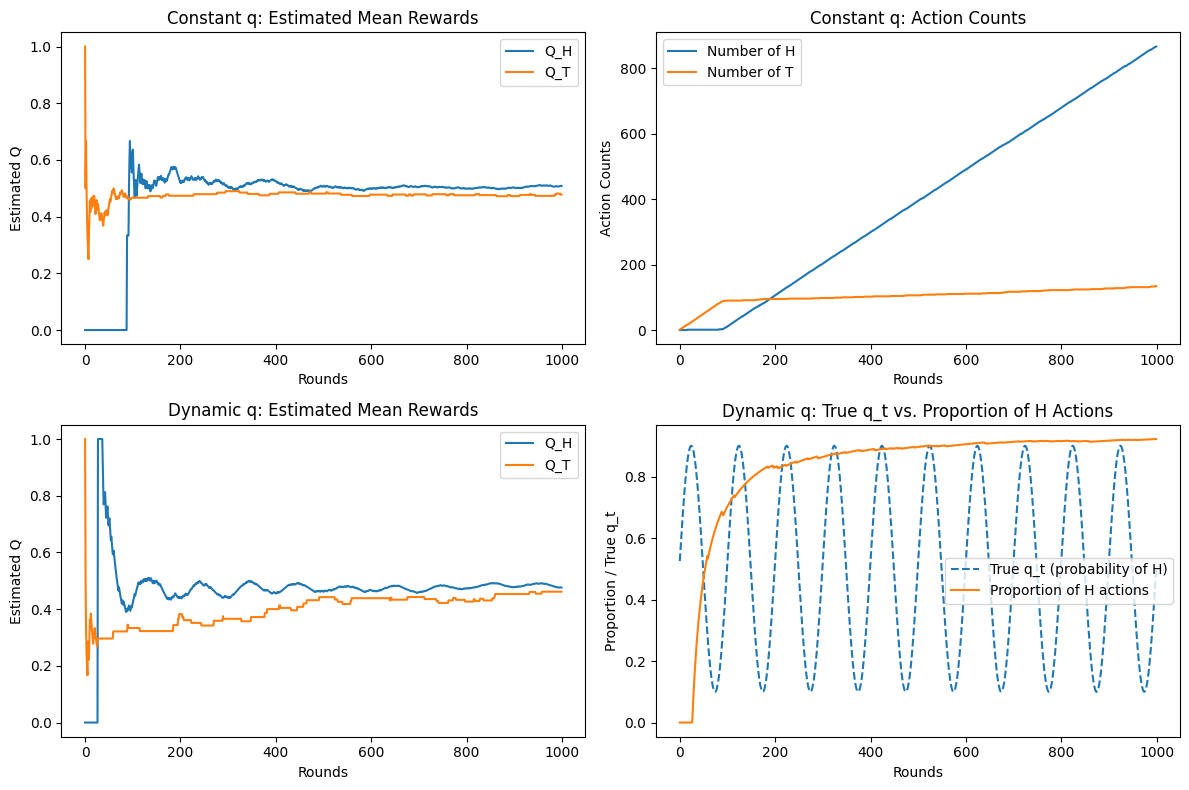

In [18]:
# Define constants
n_rounds = 1000
epsilon = 0.1
q_constant = 0.5
q_t_func = lambda t: 0.5 + 0.4 * np.sin(2 * np.pi * t / 100)

# Run simulations
Q_H_const, Q_T_const, actions_const, rewards_const = constant_q_simulation(n_rounds, epsilon, q_constant)
Q_H_dyn, Q_T_dyn, actions_dyn, rewards_dyn, q_t_vals = dynamic_q_simulation(n_rounds, epsilon, q_t_func)

# Plot results
plt.figure(figsize=(12, 8))

# Constant q experiment plots
plt.subplot(2, 2, 1)
plt.plot(Q_H_const, label="Q_H")
plt.plot(Q_T_const, label="Q_T")
plt.title("Constant q: Estimated Mean Rewards")
plt.xlabel("Rounds")
plt.ylabel("Estimated Q")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot([hc for hc, tc in actions_const], label="Number of H")
plt.plot([tc for hc, tc in actions_const], label="Number of T")
plt.title("Constant q: Action Counts")
plt.xlabel("Rounds")
plt.ylabel("Action Counts")
plt.legend()

# Dynamic q experiment plots
plt.subplot(2, 2, 3)
plt.plot(Q_H_dyn, label="Q_H")
plt.plot(Q_T_dyn, label="Q_T")
plt.title("Dynamic q: Estimated Mean Rewards")
plt.xlabel("Rounds")
plt.ylabel("Estimated Q")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(q_t_vals, label="True q_t (probability of H)", linestyle="--")
plt.plot([hc / (hc + tc) if hc + tc > 0 else 0 for hc, tc in actions_dyn], label="Proportion of H actions")
plt.title("Dynamic q: True q_t vs. Proportion of H Actions")
plt.xlabel("Rounds")
plt.ylabel("Proportion / True q_t")
plt.legend()

plt.tight_layout()
plt.show()

### 1.4 Strategy 2: Thompson-Sampling

Thompson Sampling uses probabilistic modeling to balance the _exploration_ and _exploitation_ (we discussed these concepts above). This approach is based on Bayesian Learning i.e. we maintain a belief about the distribution of payout for each action. This is our _prior_. We then draw samples from these distributions at each time step and choose the action that corresponds to the highest sampled value.

To keep a track of "hog good each action (i.e. chosen arm) is", we updated the following:
 - $N_k(t)$: Number of times action `k` has been chosen upto time `t`
 - $Q_k(t)$: Mean payout for action `k` based on the previous outcomes


 The mean payout $Q_k(t)$ for the chosen action `k` is updated recursively using:

 $$
    Q_k(t) = \frac{N_k(t-1)}{N_k(t)} Q_k(t-1) + \frac{1}{N_k(t)} ( t(t,a_k) - Q_k(t-1) )
 $$

 where:
 - $y(t,a_k)$: Payout at time `t` for playing action `k` $\implies 1$ for success and $0$ for failure
 - $Q_k(t-1)$: The mean payout before this round
 - $N_k(t)$: The updated count of times `k` has been chosen
 

#### Application 1: Coin Flipping Problem with Variable Probability of `H`

#### Step 1:
- We choose prior distribution (before observing the data) of $H$ and $T$ to be $\beta(\alpha_H,\beta_H)$ and $\beta(\alpha_T,\beta_T)$. By this we mean that $\hat{q}_H \sim \beta(\alpha_H,\beta_H)$ gives us the initial (sampled) probability of `H` being successfull. Similarly, $\hat{q}_H \sim \beta(\alpha_T,\beta_T)$ gives us the initial (sampled) probability of `T` being successfull.
- As the time evolves, our distribution parameters will start changing according to the dynamics:
\begin{align}
    \alpha_H(t) &= \alpha_H(0) + \text{number of H guessed \textbf{correctly} from time 0 to t} \\
    \beta_H(t) &= \beta_H(0) + \text{number of H guessed \textbf{incorrectly} from time 0 to t}
\end{align}
This will give us a posterior distribution of $H$ i.e. $\beta(\alpha_H(t), \beta_H(t))$ with mean $\mathbb{E}\Big[\frac{\alpha_H(t)}{\alpha_H(t) + \beta_H(t)}\Big]$
- `posterior_H_means` and `posterior_T_means` will store the posterior means for `H` and `T`
- `p_h_func` represents $\mathbb{E}[H|t]$ i.e. the __true probability__ of getting `H` at time `t` and it remains unknown to the players. 

In [19]:
alpha_H, beta_H = 1, 1 
alpha_T, beta_T = 1, 1 

rewards = [] 
equity_curve = []  # cum rewards 
posterior_H_means = []  # Posterior mean for Heads
posterior_T_means = []  # Posterior mean for Tails

p_h_func = lambda t: 3 / 5 

#### Step 2:
(We sample only 1 round in this step for demonstration purposes)
- From the prior distributions, draw a sample $\hat{q}_H$ ($\hat{q}_T$) which will give us the probability that choosing `H` (`T`) will result in success i.e. if the distribution at the previous time-step was $\beta(\alpha_H(t-1), \beta_T(t-1))$, then at time $t$, we will sample $\hat{q}_H(t)$ which will give us the __current belief__ about success probability of `H`. So, we have our current samples as:
\begin{align}
    \hat{q}_H(t) &\sim \beta \Big( \alpha_H(t-1), \beta_H(t-1) \Big) \\
    \hat{q}_T(t) &\sim \beta \Big( \alpha_T(t-1), \beta_T(t-1) \Big) 
\end{align}
- Now that we have the current belief about success probabilities, we choose the action (between `H` and `T`) whose success probability is higher i.e.
$$
    a_t = \argmax_{\{H,T\}} \{\hat{q}_H(t), \hat{q}_T(t)\}
$$
$a_t = a_{\text{pred}}$
- __How do we resolve the situations where the samples from `H` action and `T` action were equal for a particular round?__ We simply pick randomly from `H` and `T`
- `outcome` ($a_{\text{true}}$) is the true action which we obtain on the basis of $\mathbb{P}[H|T]$ i.e. `p_h_t`.
- The player is rewarded with `+1` for the correct answer i.e.
\begin{equation}
    r_t =
    \begin{cases}
    1 & {\text{if }}a_{\text{true}} = a_{\text{pred}} \\
    0 & {\text{otherwise}}
    \end{cases}
\end{equation}
- In the last part, based on the player's reward, the distribution is updated based on the distribution dynamics described in the previous step

In [29]:
# Step 2: simulate one round
t = 1
p_h_t = p_h_func(t)  

# sample from the current Beta distributions
sample_H = np.random.beta(alpha_H, beta_H)
sample_T = np.random.beta(alpha_T, beta_T)

# play the action with maximum winning current belief 
if sample_H == sample_T:
    action = random.choice(["H", "T"])
else:
    action = "H" if sample_H > sample_T else "T"


# simulate the coin flip and get the true action
outcome = "H" if random.random() < p_h_t else "T"
reward = 1 if action == outcome else 0

# update Beta distribution params for the chosen action and hence the distribution too!
if action == "H":
    alpha_H += reward
    beta_H += 1 - reward
else:
    alpha_T += reward
    beta_T += 1 - reward

# track the metrics
rewards.append(reward)
equity_curve.append(sum(rewards))
posterior_H_means.append(alpha_H / (alpha_H + beta_H))
posterior_T_means.append(alpha_T / (alpha_T + beta_T))

# print results for the first round
print(f"Round: {t}")
print(f"P(H|t): {p_h_t:.2f}")
print(f"Action: {action}, Outcome: {outcome}, Reward: {reward}")
print(f"Alpha_H: {alpha_H}, Beta_H: {beta_H}")
print(f"Alpha_T: {alpha_T}, Beta_T: {beta_T}")
print(f"Posterior Mean (H): {posterior_H_means[-1]:.2f}")
print(f"Posterior Mean (T): {posterior_T_means[-1]:.2f}")

Round: 1
P(H|t): 0.00
Action: H, Outcome: T, Reward: 0
Alpha_H: 1205, Beta_H: 714
Alpha_T: 33, Beta_T: 52
Posterior Mean (H): 0.63
Posterior Mean (T): 0.39


#### Step 3: 

- We now repeat the above process for `num_rounds` number of rounds.

In [30]:
num_rounds = 1000  
for t in range(2, n_rounds + 1):
    p_h_t = p_h_func(t)  # Get the current probability of Heads

    # Sample from the Beta distributions
    sample_H = np.random.beta(alpha_H, beta_H)
    sample_T = np.random.beta(alpha_T, beta_T)

    # Resolve ties randomly
    if sample_H == sample_T:
        action = random.choice(["H", "T"])
    else:
        action = "H" if sample_H > sample_T else "T"

    # flip the coin:
    # outcome = "H" if random.random() < p_h_t else "T"
    outcome = flip_coin(p_h_t)
    reward = 1 if action == outcome else 0

    # Update Beta distribution for the chosen action
    if action == "H":
        alpha_H += reward
        beta_H += 1 - reward
    else:
        alpha_T += reward
        beta_T += 1 - reward

    # Track metrics
    rewards.append(reward)
    equity_curve.append(sum(rewards))
    posterior_H_means.append(alpha_H / (alpha_H + beta_H))
    posterior_T_means.append(alpha_T / (alpha_T + beta_T))

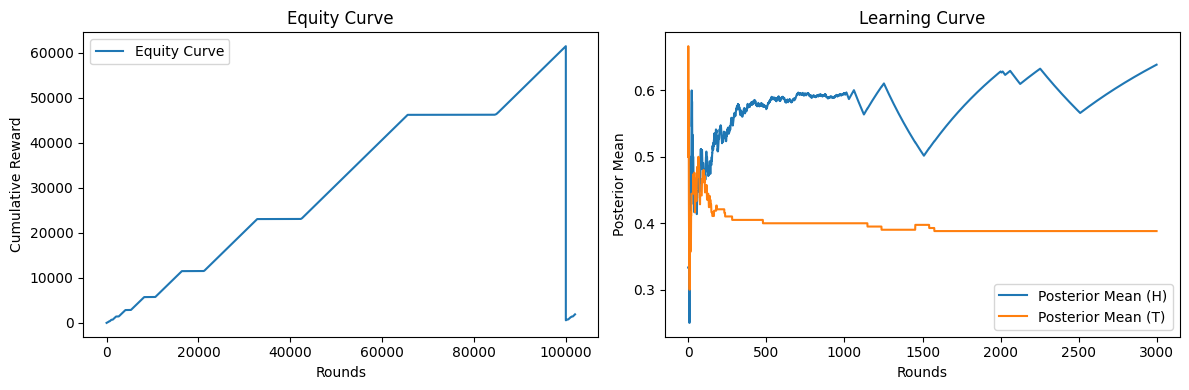

In [31]:
# Plot Equity Curve
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(equity_curve, label="Equity Curve")
plt.title("Equity Curve")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()

# Plot Learning Curve
plt.subplot(1, 2, 2)
plt.plot(posterior_H_means, label="Posterior Mean (H)")
plt.plot(posterior_T_means, label="Posterior Mean (T)")
plt.title("Learning Curve")
plt.xlabel("Rounds")
plt.ylabel("Posterior Mean")
plt.legend()

plt.tight_layout()
plt.show()

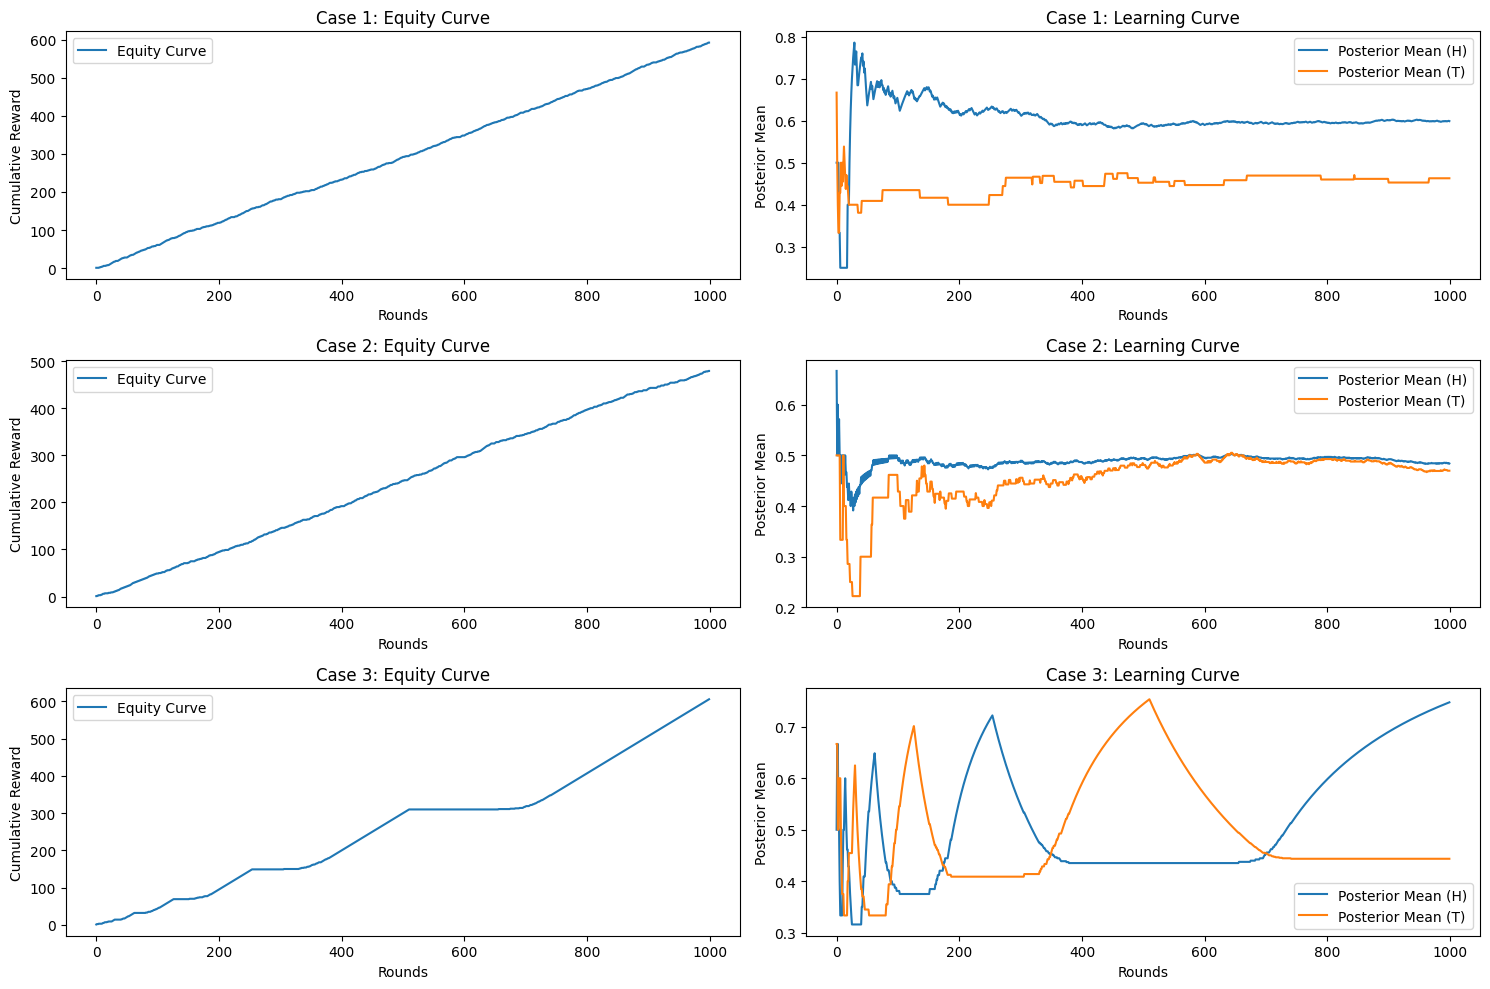

In [32]:

# Probability functions
p_h_cases = [
    lambda t: 3 / 5,  # Case 1: Constant 3/5
    lambda t: t % 2,  # Case 2: Alternates between 0 and 1
    lambda t: math.floor(math.log(t) / math.log(2)) % 2  # Case 3: Logarithmic periodic
]

# Simulate and plot results
n_rounds = 1000
plt.figure(figsize=(15, 10))

for i, p_h_func in enumerate(p_h_cases):
    equity_curve, posterior_H, posterior_T = simulate_thompson_sampling(n_rounds, p_h_func)

    # Plot Equity Curve
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(equity_curve, label="Equity Curve")
    plt.title(f"Case {i+1}: Equity Curve")
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Reward")
    plt.legend()

    # Plot Learning Curve
    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(posterior_H, label="Posterior Mean (H)")
    plt.plot(posterior_T, label="Posterior Mean (T)")
    plt.title(f"Case {i+1}: Learning Curve")
    plt.xlabel("Rounds")
    plt.ylabel("Posterior Mean")
    plt.legend()

plt.tight_layout()
plt.show()


In [33]:
# let us look at the cumulative rewards (equity) on the single plot (1 million rounds):
num_rounds = 100000
equity_curves_all = []
for p_h_func in p_h_cases:
    equity_curve, _, _ = simulate_thompson_sampling(num_rounds, p_h_func)
    equity_curves_all.append(equity_curve)
    print("--Done--")

--Done--
--Done--
--Done--


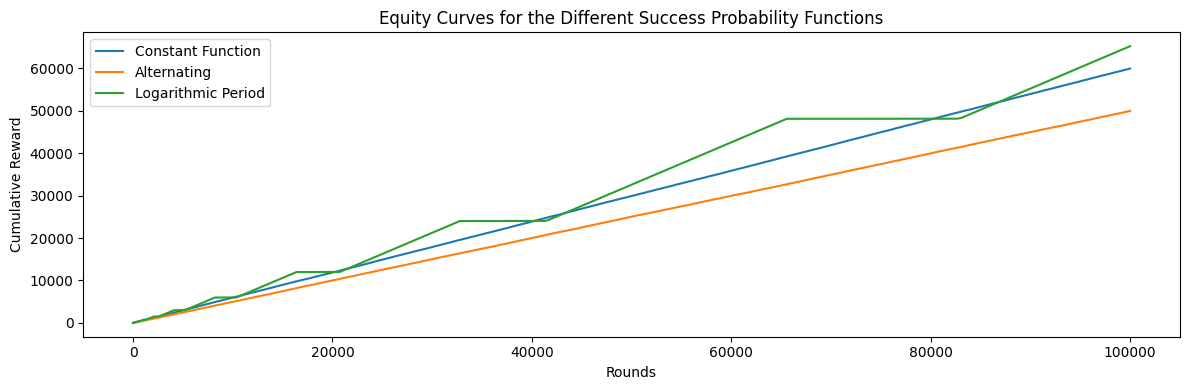

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(equity_curves_all[0], label="Constant Function")
plt.plot(equity_curves_all[1], label="Alternating")
plt.plot(equity_curves_all[2], label="Logarithmic Period")
plt.title("Equity Curves for the Different Success Probability Functions")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()

plt.tight_layout()
filename = results_path/"plots/equity_curves.png"
plt.savefig(filename, dpi=300)
plt.show()